In [1]:
import pandas as pd
import numpy as np

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters


In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

In [2]:
import torch
from torch import nn, optim

In [3]:
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Confirmed_archived_0325.csv'
df = pd.read_csv(url, index_col=0)
print(df.head(5))

               Country/Region      Lat      Long  1/22/20  1/23/20  1/24/20  \
Province/State                                                                
NaN                  Thailand  15.0000  101.0000        2        3        5   
NaN                     Japan  36.0000  138.0000        2        1        2   
NaN                 Singapore   1.2833  103.8333        0        1        3   
NaN                     Nepal  28.1667   84.2500        0        0        0   
NaN                  Malaysia   2.5000  112.5000        0        0        0   

                1/25/20  1/26/20  1/27/20  1/28/20  ...  3/14/20  3/15/20  \
Province/State                                      ...                     
NaN                   7        8        8       14  ...       82      114   
NaN                   2        4        4        7  ...      773      839   
NaN                   3        4        5        7  ...      212      226   
NaN                   1        1        1        1  ...      

In [4]:
dfn = df.iloc[:, 3:]
print(dfn.head(5))

                1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Province/State                                                                  
NaN                   2        3        5        7        8        8       14   
NaN                   2        1        2        2        4        4        7   
NaN                   0        1        3        3        4        5        7   
NaN                   0        0        0        1        1        1        1   
NaN                   0        0        0        3        4        4        4   

                1/29/20  1/30/20  1/31/20  ...  3/14/20  3/15/20  3/16/20  \
Province/State                             ...                              
NaN                  14       14       19  ...       82      114      147   
NaN                   7       11       15  ...      773      839      825   
NaN                   7       10       13  ...      212      226      243   
NaN                   1        1        1  ... 

In [5]:
dfnn=dfn.iloc[:, : 41]
print(dfnn.head(5))

                1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Province/State                                                                  
NaN                   2        3        5        7        8        8       14   
NaN                   2        1        2        2        4        4        7   
NaN                   0        1        3        3        4        5        7   
NaN                   0        0        0        1        1        1        1   
NaN                   0        0        0        3        4        4        4   

                1/29/20  1/30/20  1/31/20  ...  2/22/20  2/23/20  2/24/20  \
Province/State                             ...                              
NaN                  14       14       19  ...       35       35       35   
NaN                   7       11       15  ...      122      147      159   
NaN                   7       10       13  ...       85       89       89   
NaN                   1        1        1  ... 

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
daily_cases = dfnn.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

(array([18283., 18293., 18300., 18307., 18314., 18322.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

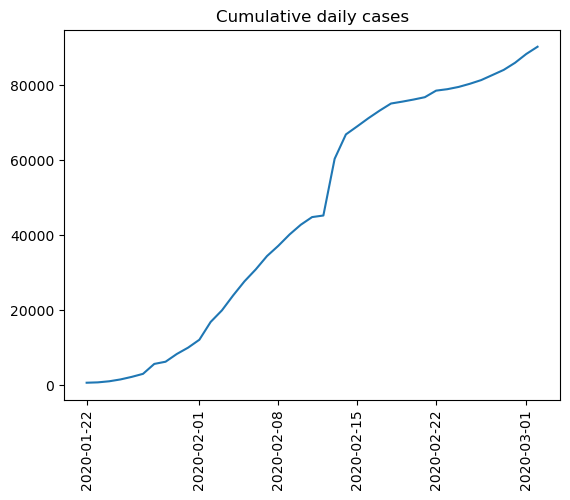

In [8]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

In [9]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

(array([18283., 18293., 18300., 18307., 18314., 18322.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

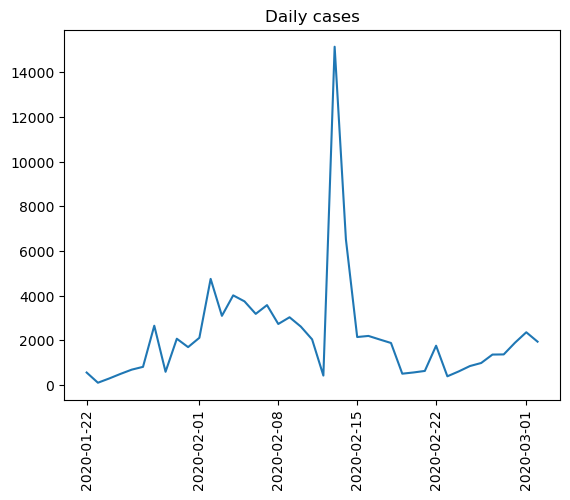

In [10]:
plt.plot(daily_cases)
plt.title("Daily cases");
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

The huge spike (in the middle) is mostly due to a change of criteria for testing patients in China. This will certainly be a challenge for our model.

In [11]:
daily_cases.shape

(41,)

We have data for 240 days!

We'll reserve the first 160 days for training and use the rest for testing:

In [12]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(27,)

Preprocessing

In [13]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [14]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [15]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
X_train.shape

torch.Size([21, 5, 1])

In [17]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [18]:
y_train.shape

torch.Size([21, 1])

In [19]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [20]:
train_data[:10]

array([[0.03036747],
       [0.        ],
       [0.01262542],
       [0.02624759],
       [0.03893946],
       [0.04724566],
       [0.16964582],
       [0.0325603 ],
       [0.13090571],
       [0.10598711]])

In [21]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [22]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 50

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [54]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.7339515686035156 test loss: 0.05380978062748909
Epoch 10 train loss: 0.8515231609344482 test loss: 0.10396935790777206
Epoch 20 train loss: 0.8187564015388489 test loss: 0.1505921483039856
Epoch 30 train loss: 0.8141531944274902 test loss: 0.19098667800426483
Epoch 40 train loss: 0.8223068118095398 test loss: 0.16399098932743073


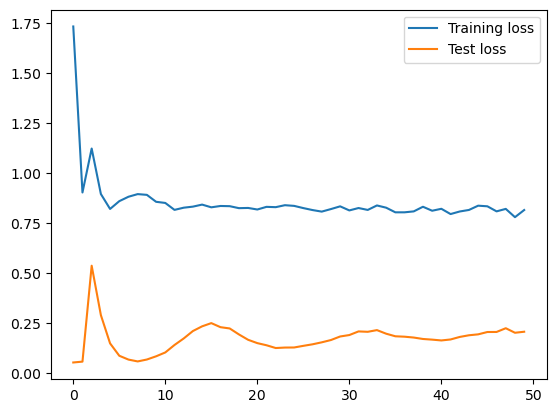

In [55]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

In [56]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

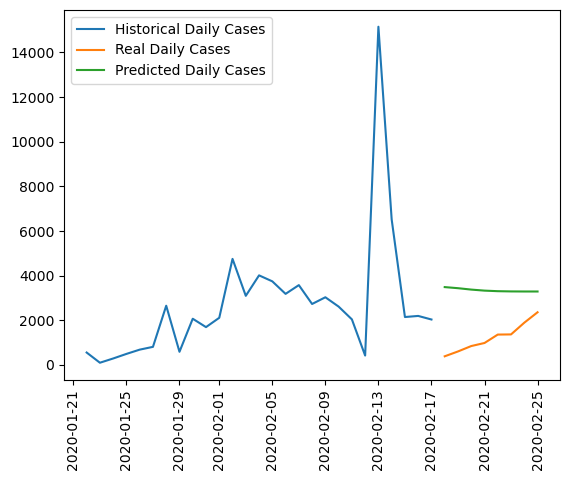

In [57]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.legend();

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

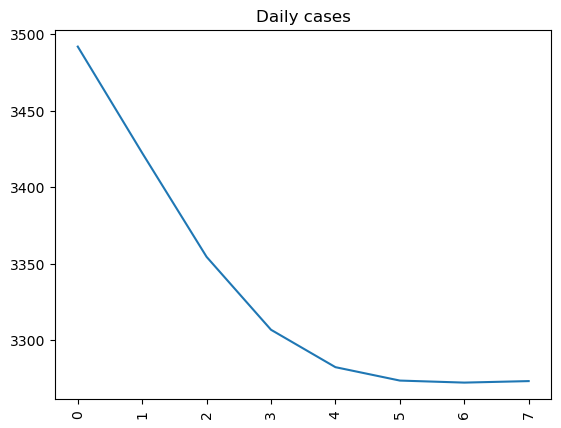

In [34]:
plt.plot(predicted_cases)
plt.title("Daily cases");
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

In [35]:
print(predicted_cases)

[3491.91640671 3422.37588827 3354.39613296 3306.71459538 3282.25165169
 3273.48626249 3272.15781985 3273.14002423]


In [36]:
print(true_cases)

[ 386.  603.  845.  982. 1359. 1366. 1891. 2358.]


In [37]:
atrue_cases= true_cases+2000

In [38]:
print(atrue_cases)

[2386. 2603. 2845. 2982. 3359. 3366. 3891. 4358.]


In [39]:
forecast_error = true_cases - predicted_cases
mean_forecast_error = mean(forecast_error)
print(mean_forecast_error)

-2110.8048476967956


In [40]:
expected = atrue_cases
predictions = predicted_cases
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 479210.980648


In [41]:
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 692.250663


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

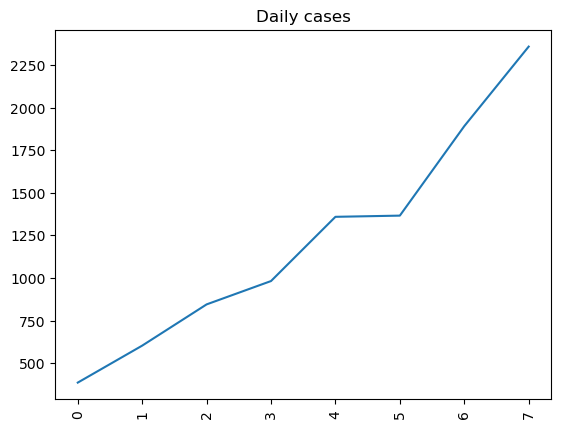

In [42]:
plt.plot(true_cases)
plt.title("Daily cases");
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)

In [43]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(41, 1)

In [44]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.5974836349487305
Epoch 10 train loss: 0.8637474775314331
Epoch 20 train loss: 0.832682192325592
Epoch 30 train loss: 0.812546968460083
Epoch 40 train loss: 0.812580406665802


In [40]:
DAYS_TO_PREDICT = 12
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [41]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [42]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

C:\Users\abhis\AppData\Local\Temp\ipykernel_12736\1104263272.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


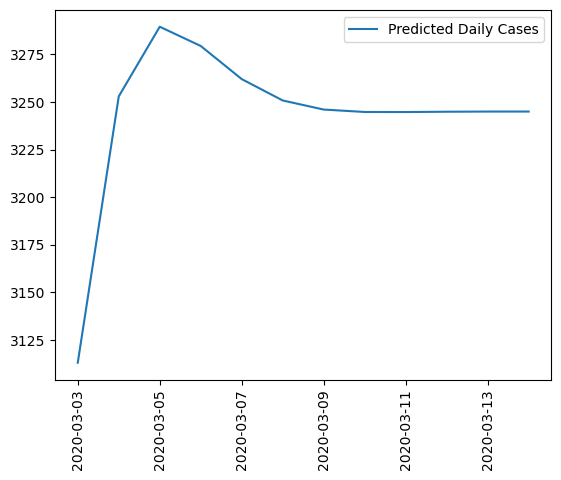

In [45]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.legend();

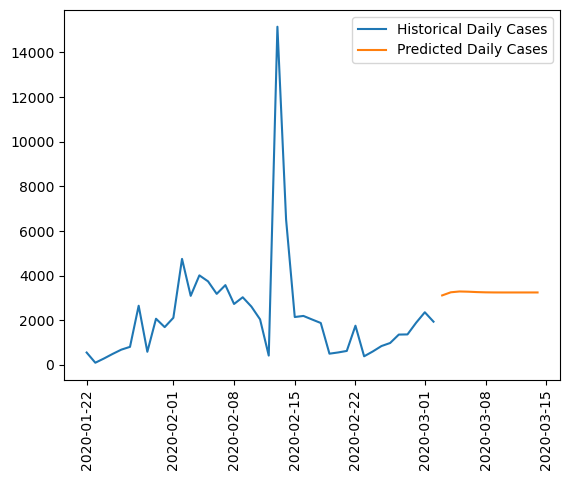

In [48]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.legend();